In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PIL for visualization
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
%matplotlib inline

In [9]:
SSD_GRAPH_FILE = 'frozen_inference_graph.pb'

In [10]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


In [11]:
detection_graph = load_graph(SSD_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [16]:
# Load a sample image.
image = Image.open('assets/sample1.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)
    print(classes)

    

[18. 18.]


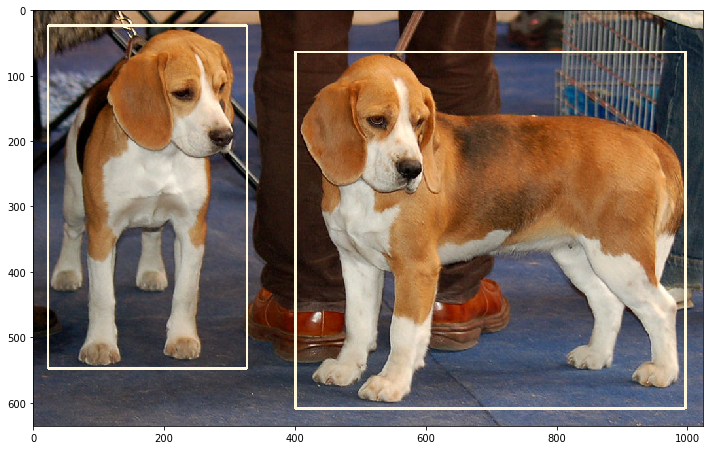

In [18]:
plt.figure(figsize=(12, 8))
plt.imshow(image)